In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

Reading in the Manhattan Crime DataFrame

In [252]:
df = pd.read_csv('df_mhtn.csv', index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [254]:
df.head()

,date_time,ADDR_PCT_CD,LAW_CAT_CD,Latitude,Longitude,date,time
0,2006-01-01 00:01:00,5.0,MISDEMEANOR,40.721883,-73.997263,2006-01-01,00:01:00
1,2006-01-01 00:01:00,24.0,MISDEMEANOR,40.796571,-73.967186,2006-01-01,00:01:00
2,2006-01-01 00:01:00,9.0,MISDEMEANOR,40.730066,-73.980615,2006-01-01,00:01:00
3,2006-01-01 00:01:00,18.0,MISDEMEANOR,40.761311,-73.973083,2006-01-01,00:01:00
4,2006-01-01 00:01:00,13.0,MISDEMEANOR,40.734346,-73.981935,2006-01-01,00:01:00


In [6]:
#Giving each row a value of 1 for number of crimes because each row is an individual crime
df['number_of_crimes'] = 1

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [45]:
#Create 3 new DataFrames for each type of crime
df_misdemeanor = df.loc[df['LAW_CAT_CD'] == 'MISDEMEANOR']
df_felony = df.loc[df['LAW_CAT_CD'] == 'FELONY']
df_violation = df.loc[df['LAW_CAT_CD'] == 'VIOLATION']

In [46]:
df_misdemeanor = df_misdemeanor.reset_index()
df_felony = df_felony.reset_index()
df_violation = df_violation.reset_index()

In [47]:
#Setting date to be the index for a Time Series Analysis
df_misdemeanor.set_index(['date'], inplace=True, drop=True)
df_felony.set_index(['date'], inplace=True, drop=True)
df_violation.set_index(['date'], inplace=True, drop=True)

In [48]:
#Aggregating crime data to sum of crimes per week
df_misdemeanor = pd.DataFrame(df_misdemeanor['number_of_crimes'].resample('W', how='sum'))
df_felony = pd.DataFrame(df_felony['number_of_crimes'].resample('W', how='sum'))
df_violation = pd.DataFrame(df_violation['number_of_crimes'].resample('W', how='sum'))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


Plotting the 3 Crime DataFrames

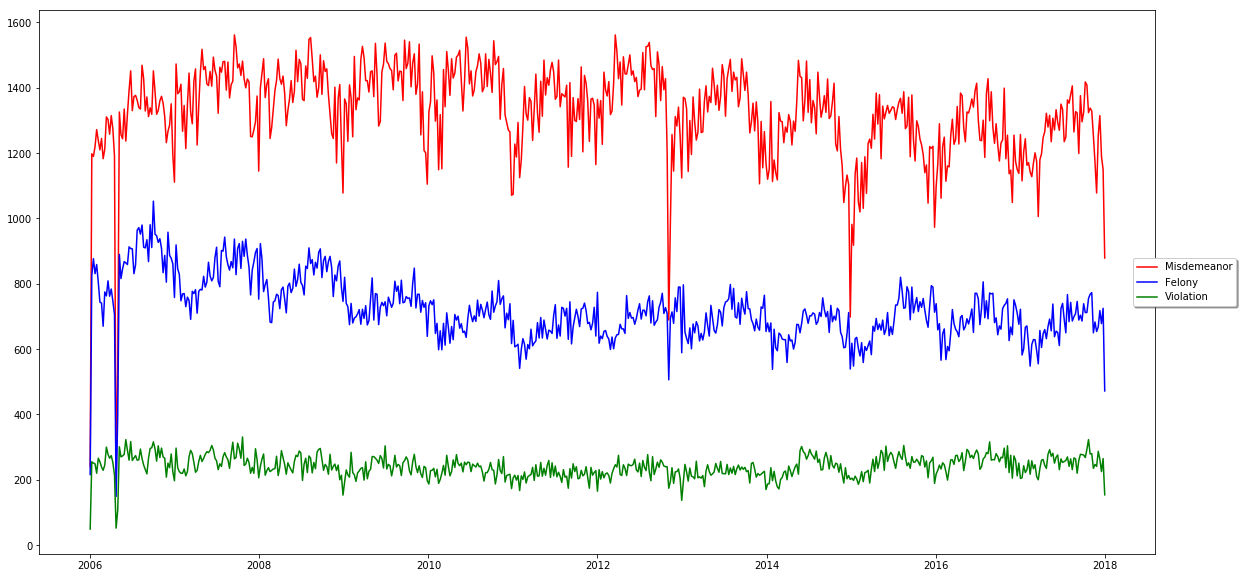

In [259]:
plt.figure(figsize=(20,10))
plt.plot(df_misdemeanor, color='r', label= 'Misdemeanor')
plt.plot(df_felony, color='b', label= 'Felony')
plt.plot(df_violation, color='g', label= 'Violation')
plt.legend(loc='center left', bbox_to_anchor=(0.975, 0.5), fancybox=True, shadow=True)
plt.show()

In [56]:
#Defining a function to plot the data series with differencing and provide the Dickey-Fuller p-value
#Additionally the function plots the ACF and PACF (Autocorrelation and Partial Autocorrelation)

def correlationplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [58]:
#Performing a differencing of 52 weeks to take away the yearly seasonality of the data series
misdemeanor_diff = df_misdemeanor['number_of_crimes'] - df_misdemeanor['number_of_crimes'].shift(52)

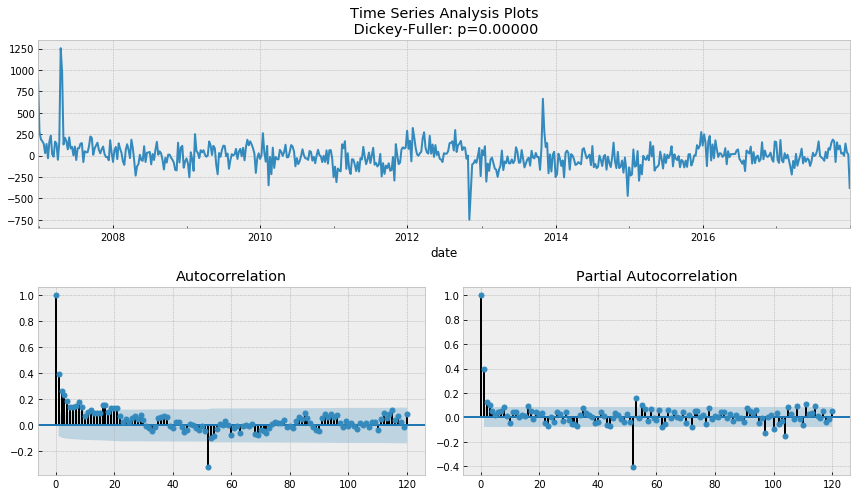

In [61]:
correlationplot(misdemeanor_diff[52:], lags=120)

In [166]:
#Create a parameters list for the SARIMA model. The parameters are from analyzing the correlation plots
# The p is probably 2 or 3.
# The d is 1.
# The q is between 6 and 7.
# The length of a season is 52.

ps = range(2,4)
d = range(1,2)
qs = range(6,8)
Ps = range(1,2)
D = range(1,2)
Qs = range(1,2)
s = 52

parameters = product(ps, d, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [167]:
parameters_list

[(2, 1, 6, 1, 1, 1),
 (2, 1, 7, 1, 1, 1),
 (3, 1, 6, 1, 1, 1),
 (3, 1, 7, 1, 1, 1)]

In [152]:
#Defining a function that will output a table of the parameters and AIC values for the inputted dataframe

def optimizeSARIMA(dataframe, param_list, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm(param_list):
        # we need try-except because on some combinations model may fail to converge
        try:
            model=sm.tsa.statespace.SARIMAX(dataframe, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    #result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [137]:
#Making a Train/Test Split
misdemeanor_train = df_misdemeanor[:(int(len(df_misdemeanor)*0.8))]
misdemeanor_test = df_misdemeanor[(int(len(df_misdemeanor)*0.8)):]

In [171]:
#Finding the optimal parameters for SARIMA
train_results = optimizeSARIMA(misdemeanor_train, parameters_list, s)
train_results.head()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,parameters,aic
0,"(2, 1, 6, 1, 1, 1)",5549.228913
1,"(3, 1, 6, 1, 1, 1)",5550.461327
2,"(3, 1, 7, 1, 1, 1)",5550.847674
3,"(2, 1, 7, 1, 1, 1)",5552.562874


In [173]:
#The optimal parameters for SARIMA are is the 1st index of the results table

p, d, q, P, D, Q = train_results.parameters[0]

misdem_best_train_model=sm.tsa.statespace.SARIMAX(misdemeanor_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [172]:
#Defining a function that will use the training data of a data series and make a prediction of the specified amount
#The predictions will be compared to the testing data and output the mean absolute percentage error of the two

def plotSARIMAtraining(series, model, n_steps):
    
    #train/test split
    data = series.copy()
    data_train = data[:(int(len(data)*0.8))]
    data_test = data[(int(len(data)*0.8)):]
    data_test.columns = ['actual']
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data_train.shape[0], end = data_train.shape[0]+n_steps-1)
    forecast = pd.DataFrame(forecast, columns=['arima_model'])
    forecast.dropna(inplace=True)
    arima_forecast = pd.concat([forecast, data_test], axis=1)
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(arima_forecast['actual'], arima_forecast['arima_model'])
    
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(series, color='b', label='actual')
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data_test.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data, label="actual")
    plt.legend()
    plt.grid(True);

In [150]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


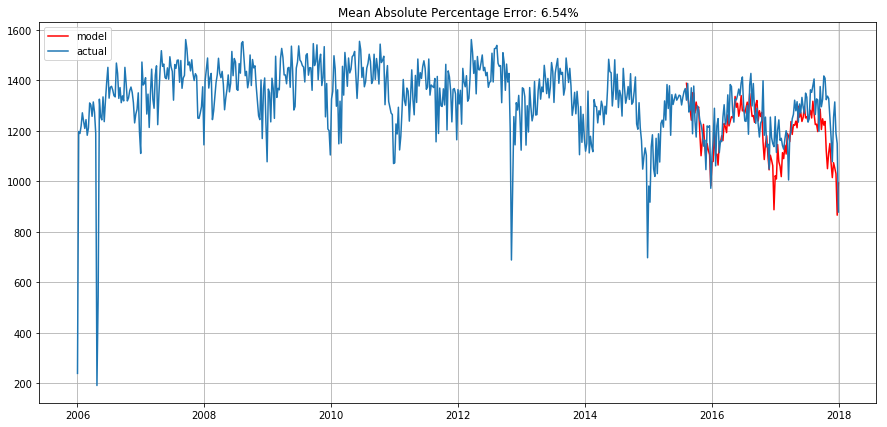

In [174]:
plotSARIMAtraining(df_misdemeanor, misdem_best_train_model, 126)

## Performing forecasting using the entire data series

In [175]:
p, d, q, P, D, Q = train_results.parameters[0]

final_misdemeanor_model=sm.tsa.statespace.SARIMAX(df_misdemeanor, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [228]:
def plotSARIMA(series, model, n_steps):
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, dynamic=True)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast[data.shape[0]:], color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


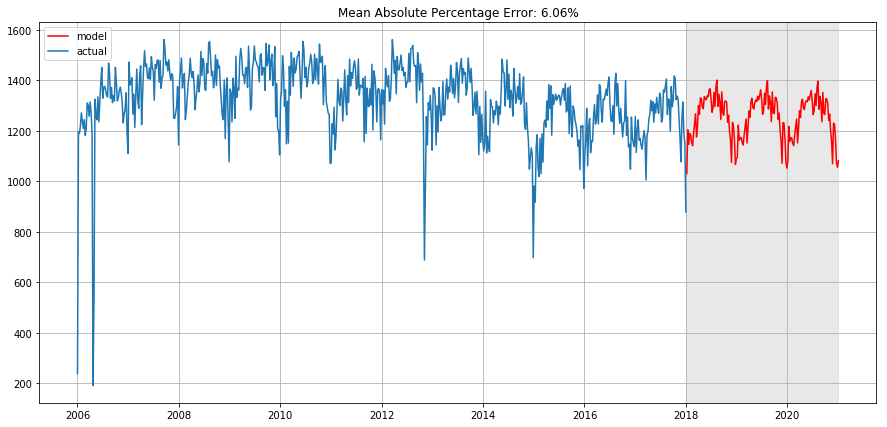

In [229]:
plotSARIMA(df_misdemeanor, final_misdemeanor_model, 156)

In [230]:
#Function to save the forecasted values

def saveforecasts(series, model, n_steps):
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps, dynamic=True)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    return forecast[data.shape[0]:]

In [243]:
misdemeanor_forecast = pd.DataFrame(saveforecasts(df_misdemeanor, final_misdemeanor_model, 156), columns=['number_of_crimes'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [246]:
misdemeanor_forecast.to_csv('misdemeanor_forecast.csv')

In [248]:
df_misdemeanor.to_csv('df_misdemeanor.csv')